In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

In [374]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 5
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
uniq_vals_recorded = []
cluster_allocs_recorded = []

In [232]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
            #uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata, lam)
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot)
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
        else:
            print("sono qua")
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_prior_Wasserstein_NW_log(lam, uniq_vals, h,count,count_tot)

    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    #print(weights)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    #print(cluster_allocs)
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    global uniq_vals_recorded
    uniq_vals_recorded = uniq_vals
    
    return cluster_allocs, uniq_vals, weights,count,count_tot




def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    count = 0
    count_tot = 0
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        #[[5,5],[-5,-5],[10,-10],[-10,10]],
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights ,count,count_tot = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print(uniq_vals)
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out

In [439]:
def sigmoid(x):
    return (1 - np.exp(-x))/(1 + np.exp(-x))


def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop = np.eye(2)
    nu_prop = 1000

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using a centered Normal Wishart
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NW(mu_n, cov_prop, np.linalg.inv(phi_n), nu_prop)

    #print("Mu_old: " + str(mu_old))
    #print("Mu: " + str(mu))
    #print("Cov_old: " + str(cov_old))
    #print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop)
    
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
        #print("beta: " + str(beta) + " rejected")
    else:
        count = count + 1
        #print("beta: " + str(beta) + " accepted")
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot


def sample_uniq_vals_prior_Wasserstein_NW_log(lam, uniq_vals, h,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop = np.eye(2)
    nu_prop = 1000

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    
    mu_0 = np.mean(np.array(data), axis= 0)
    lam_0 = lam
    phi_0 = np.diag(np.ones(d))
    nu_0 = d

    # Sample the proposal using a centered Normal Wishart
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NW(mu_n, cov_prop, np.linalg.inv(phi_n), nu_prop)

    #print("Mu_old: " + str(mu_old))
    #print("Mu: " + str(mu))
    #print("Cov_old: " + str(cov_old))
    #print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_0, lam_0, phi_0, nu_0, mu_old, cov_old,cov_prop,nu_prop)
    
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
        #print("beta: " + str(beta) + " rejected")
    else:
        count = count + 1
        #print("beta: " + str(beta) + " accepted")
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot



def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    #print("n: " + str(n))
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NW(mu, cov_prop, sigma, a):
    """
    Sample from a NW given its parameters
    """
    chol = np.linalg.cholesky(sigma/a)
    cov = tfd.WishartTriL(df=a, scale_tril=chol).sample()
    
    draw = tfd.Uniform().sample()
    if draw > 0.05:
        mu = tfd.MultivariateNormalFullCovariance(mu, cov_prop).sample()
    else:
        print("PROVA ESTREMA")
        muprop = tfd.Normal(30, 10).sample()
        mu = tfd.MultivariateNormalFullCovariance([muprop,-muprop], cov_prop).sample()
        print("MU " + str(mu))
    return mu, cov


def compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop):
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    prop_num = evaluate_NW_log(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
    prop_den = evaluate_NW_log(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

    # Wasserstein Distances
    sum_ = 0
    #for j in range(k):
    #    if(j != k):
    #        mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
    #        cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
    #        sum_ = sum_ + np.log(sigmoid(compute_Wasserstein(mu , cov , mu_k , cov_k))) - np.log(sigmoid(compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)))


    
    print("num_1" + str(num_1))
    print("sum" + str(50*sum_))
    print("den_1" + str(den_1))
    print("prop_num" + str(prop_num))
    print("prop_den" + str(prop_den))
    return num_1 + 500 * sum_ - den_1 + prop_num - prop_den


def evaluate_NIW_log(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).log_prob(x_mu)
    return f1 + f2


def evaluate_NW_log(mu , cov, mu_center , cov_param , cov_center , nu_param):

    cov_center_chol = np.linalg.cholesky(cov_center/nu_param)
    f1 = tfd.WishartTriL(df=nu_param, scale_tril=cov_center_chol).log_prob(cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_center, cov_param).log_prob(mu)
    return f1+f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, uniq_vals):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    #for i in range(len(probs)):
    #    if np.sum(probs[i]) != 1:
    #        probs[i] = np.zeros(k)
    #        idx = np.random.randint(0,k)
    #        probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()





In [96]:
def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata, lam):
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [440]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k , niter = 500,nburn = 200)
end = time.time()
print("Total time: " + str(end-start))


num_1-39732.44298161935
sum0
den_1-35046.20680222895
prop_num0.10582337957546528
prop_den0.5744048301019369
Accept Rate:0.0
num_1-517891.27035819576
sum0
den_1-480028.55930303346
prop_num9.779028109864415
prop_den9.809768854378747
Accept Rate:0.0
num_1-12623.382622305571
sum0
den_1-13179.122694820131
prop_num6.093579348999375
prop_den6.034796798644512
Accept Rate:0.3333333333333333
num_1-22457.474415022138
sum0
den_1-20006.274765597464
prop_num9.868694882706478
prop_den9.885064930949994
Accept Rate:0.25
num_1-916.3809669154748
sum0
den_1-669.6680002064621
prop_num-1.3164621899425617
prop_den-0.9681231994271036
Accept Rate:0.2
[[[ 0.01802955  3.53870727 -1.73465557]
  [ 0.5273424  -1.73465557  1.01872209]]

 [[ 0.36797607  0.58786157  0.22209159]
  [-0.16853359  0.22209159  0.08606993]]

 [[ 0.6012083   0.23248767  0.39891909]
  [ 0.53534488  0.39891909  1.69061115]]

 [[-0.4708534   1.50890808  1.59214321]
  [ 0.15222743  1.59214321  1.70219167]]

 [[ 0.1926602   2.79335333  1.83873878

[[[-2.5447055   2.66485191 -1.30875699]
  [ 1.05757157 -1.30875699  0.79244936]]

 [[ 0.36797607  0.58786157  0.22209159]
  [-0.16853359  0.22209159  0.08606993]]

 [[ 1.24514833  0.26886647  0.45871479]
  [ 0.49634546  0.45871479  1.88490614]]

 [[ 1.47213533  1.33973366  1.39632066]
  [ 0.762143    1.39632066  1.48101432]]

 [[ 1.30803563  3.14852659  2.05448702]
  [ 0.93561958  2.05448702  3.32016495]]]
Iter 11 / 500 Remaining minutes: 7.9 sono qua
num_1-11.408493483377079
sum0
den_1-11.136006025300482
prop_num5.810861613627319
prop_den5.771443663991429
Accept Rate:0.375
sono qua
num_1-276.4531555725464
sum0
den_1-273.955015186972
prop_num13.143356500198491
prop_den13.016168053557989
Accept Rate:0.3684210526315789
sono qua
num_1-10.401626649777201
sum0
den_1-10.733350338683856
prop_num6.49807309829849
prop_den6.4898941053410075
Accept Rate:0.3793103448275862
sono qua
num_1-49.47924542499621
sum0
den_1-48.96150731221538
prop_num9.392175751037819
prop_den9.473954896528873
Accept Rate:

num_1-37682.941213117556
sum0
den_1-261.679086320744
prop_num-884.7769446696793
prop_den-884.863810398956
Accept Rate:0.4485981308411215
sono qua
num_1-10.893973626711137
sum0
den_1-10.972744048914917
prop_num5.779067224622054
prop_den5.797718411182245
Accept Rate:0.4537037037037037
sono qua
num_1-61.541095893192264
sum0
den_1-39.580568170327425
prop_num2.782329223731912
prop_den3.249959003136345
Accept Rate:0.44954128440366975
num_1-3369.3348877003687
sum0
den_1-3108.4427805919386
prop_num-0.6731224092035477
prop_den-0.6975563703106404
Accept Rate:0.44545454545454544
sono qua
num_1-11.608882067172182
sum0
den_1-11.85617591105488
prop_num3.7310326519502506
prop_den3.6413778096043425
Accept Rate:0.45045045045045046
sono qua
num_1-266.16942682322747
sum0
den_1-261.679086320744
prop_num11.588350434958254
prop_den11.414902983343989
Accept Rate:0.45535714285714285
sono qua
num_1-11.24051014974289
sum0
den_1-10.893973626711137
prop_num5.015176279870647
prop_den5.065516935628156
Accept Rate:0

sono qua
num_1-10.308603048937009
sum0
den_1-10.464702117906619
prop_num4.127685124732254
prop_den4.2016892286070675
Accept Rate:0.43478260869565216
sono qua
num_1-230.79531431785952
sum0
den_1-228.84170252619677
prop_num12.58510185523642
prop_den12.414090399923001
Accept Rate:0.43209876543209874
sono qua
PROVA ESTREMA
MU [ 35.64059805 -33.21585484]
num_1-700.0006034262475
sum0
den_1-11.542936423045537
prop_num-1089.4155155829822
prop_den-1089.607423270759
Accept Rate:0.4294478527607362
num_1-243.78998384824342
sum0
den_1-203.94835193633372
prop_num9.097700463529165
prop_den9.056387638755425
Accept Rate:0.4268292682926829
num_1-2944.8189334752306
sum0
den_1-2601.9632331773983
prop_num0.7398924571859657
prop_den0.7772418775200327
Accept Rate:0.42424242424242425
sono qua
num_1-10.635162072167992
sum0
den_1-10.308603048937009
prop_num5.049331297418129
prop_den5.086001626235437
Accept Rate:0.42168674698795183
sono qua
num_1-401.94071321458443
sum0
den_1-228.84170252619677
prop_num8.2959007

num_1-160.7832185452022
sum0
den_1-128.88838768514375
prop_num6.917582269576613
prop_den7.260285878156608
Accept Rate:0.411214953271028
num_1-2137.880908936789
sum0
den_1-2089.9499241912176
prop_num1.3852313612345304
prop_den1.3436125562796795
Accept Rate:0.40930232558139534
sono qua
num_1-9.975779909907658
sum0
den_1-10.097285731781003
prop_num3.68367961179171
prop_den3.3618579389427548
Accept Rate:0.41203703703703703
sono qua
num_1-204.33128643226124
sum0
den_1-210.97722803694032
prop_num10.70622563115414
prop_den11.006399274283396
Accept Rate:0.4147465437788018
sono qua
num_1-11.421951066821496
sum0
den_1-11.017699023003042
prop_num5.76149589443648
prop_den5.788383904101779
Accept Rate:0.41743119266055045
num_1-438.9019258935619
sum0
den_1-110.91271950954797
prop_num7.120457792876833
prop_den7.213188872343208
Accept Rate:0.4155251141552511
num_1-2186.055482788689
sum0
den_1-2107.5694386323094
prop_num-1.8451350221898597
prop_den-2.159853439742145
Accept Rate:0.41363636363636364
sono

num_1-1991.4111425707
sum0
den_1-72.45913867270176
prop_num7.331233008009145
prop_den7.366937714562278
Accept Rate:0.4052044609665427
PROVA ESTREMA
MU [ 6.53428315 -5.67187133]
num_1-32035.55626396934
sum0
den_1-1898.944988765414
prop_num-39.025143119454796
prop_den-38.903010658912066
Accept Rate:0.40370370370370373
sono qua
num_1-10.124873087949677
sum0
den_1-10.078045345991825
prop_num3.338660085598233
prop_den3.085968582937196
Accept Rate:0.4059040590405904
sono qua
num_1-179.42498616435768
sum0
den_1-183.75570404481994
prop_num12.717222800104048
prop_den12.640409278833397
Accept Rate:0.40808823529411764
sono qua
num_1-11.631733502838724
sum0
den_1-10.739704464494416
prop_num1.2918718049582631
prop_den0.7635858385463772
Accept Rate:0.4065934065934066
num_1-2543.2020656752356
sum0
den_1-65.47806716221876
prop_num6.50674070789937
prop_den6.313932407726314
Accept Rate:0.4051094890510949
num_1-2453.1030240509854
sum0
den_1-1906.547721388719
prop_num-1.247306157967393
prop_den-1.32780389

num_1-175.36931817471304
sum0
den_1-178.36004411732213
prop_num12.396000049879131
prop_den12.518697533927007
Accept Rate:0.38509316770186336
num_1-23.26610411802622
sum0
den_1-33.71490311945329
prop_num3.5671100992619333
prop_den3.906251014425786
Accept Rate:0.38699690402476783
num_1-771.9463967933078
sum0
den_1-86.21809761589881
prop_num8.708788793539775
prop_den8.642635108495874
Accept Rate:0.38580246913580246
num_1-1705.6297165493086
sum0
den_1-1802.7495598154403
prop_num0.20482347942734158
prop_den0.08617150737907231
Accept Rate:0.38769230769230767
sono qua
num_1-9.291759206955032
sum0
den_1-9.812769011519642
prop_num2.5552724736315047
prop_den2.3977379193336508
Accept Rate:0.3895705521472393
sono qua
num_1-178.75405991303853
sum0
den_1-175.36931817471304
prop_num13.17316070556689
prop_den13.172250919268382
Accept Rate:0.38837920489296635
num_1-171.15066712454265
sum0
den_1-53.413309516528685
prop_num4.485896238539887
prop_den4.352662195437894
Accept Rate:0.3871951219512195
num_1-2

num_1-160.43108081653241
sum0
den_1-159.92360663019434
prop_num12.1793162753509
prop_den12.105721087017898
Accept Rate:0.3740053050397878
num_1-134.34619676729233
sum0
den_1-41.167970390104756
prop_num3.7587902827735444
prop_den3.8980800254652888
Accept Rate:0.373015873015873
num_1-4565.558158648114
sum0
den_1-131.45746667489627
prop_num5.975222527171744
prop_den6.036496327460944
Accept Rate:0.3720316622691293
num_1-1740.6093837956219
sum0
den_1-1571.215714431362
prop_num-0.6146783798143369
prop_den-0.6152441261269823
Accept Rate:0.37105263157894736
sono qua
num_1-10.629914843514069
sum0
den_1-9.738264290287578
prop_num3.2115151782348157
prop_den3.151894487458815
Accept Rate:0.3700787401574803
sono qua
num_1-170.70100340496344
sum0
den_1-160.43108081653241
prop_num8.144072121163067
prop_den8.69533825383191
Accept Rate:0.36910994764397903
num_1-100.62973882306304
sum0
den_1-52.677437817717575
prop_num5.093714777401358
prop_den4.8887584440746945
Accept Rate:0.3681462140992167
num_1-374.3

sono qua
num_1-9.423139832713424
sum0
den_1-10.061371285225746
prop_num-0.3932921401972411
prop_den-0.004532235000420215
Accept Rate:0.35498839907192575
sono qua
num_1-144.71076588192614
sum0
den_1-144.14071089751053
prop_num12.150319480171696
prop_den12.184766250351935
Accept Rate:0.35648148148148145
num_1-43.75487508375006
sum0
den_1-24.412946879987274
prop_num2.621039740277263
prop_den3.0882712129749397
Accept Rate:0.3556581986143187
num_1-66.5366914061432
sum0
den_1-36.34281596057194
prop_num8.758052409417237
prop_den8.69653166873592
Accept Rate:0.3548387096774194
num_1-1594.3845987678878
sum0
den_1-1588.6857560694777
prop_num0.8149823088165427
prop_den0.8962082381149408
Accept Rate:0.35402298850574715
sono qua
PROVA ESTREMA
MU [ 32.97917973 -32.62422249]
num_1-95.25341611626276
sum0
den_1-9.423139832713424
prop_num-1341.2407312884256
prop_den-1341.1868351613416
Accept Rate:0.3532110091743119
sono qua
num_1-158.63986788542707
sum0
den_1-144.71076588192614
prop_num11.786440067245337

num_1-38.14085802791518
sum0
den_1-33.640465150966094
prop_num6.679738038190099
prop_den6.781034146367492
Accept Rate:0.3574380165289256
num_1-1371.293249370268
sum0
den_1-1335.5164019976464
prop_num-4.063249736606808
prop_den-4.486315579043167
Accept Rate:0.35670103092783506
sono qua
PROVA ESTREMA
MU [ 20.06893103 -20.66644011]
num_1-41.40405405647045
sum0
den_1-9.808612192631095
prop_num-606.255981628244
prop_den-606.3629691227754
Accept Rate:0.3559670781893004
sono qua
PROVA ESTREMA
MU [ 29.31788403 -30.01704081]
num_1-14894.328723848626
sum0
den_1-123.32719690678138
prop_num-839.1288601396452
prop_den-839.523552593794
Accept Rate:0.35523613963039014
num_1-53.29101400648965
sum0
den_1-32.10427817375676
prop_num4.07636801096714
prop_den4.135619743954972
Accept Rate:0.35450819672131145
sono qua
num_1-35.085849839400254
sum0
den_1-33.640465150966094
prop_num8.96596528069741
prop_den8.992103026905816
Accept Rate:0.3558282208588957
num_1-1533.0587563321958
sum0
den_1-1332.8836989562012
p

num_1-31.68294835866636
sum0
den_1-30.960644019176996
prop_num6.750151870619148
prop_den6.68505062941692
Accept Rate:0.3562152133580705
num_1-1251.1030679069943
sum0
den_1-1188.844850961147
prop_num0.8001035740971916
prop_den0.813108470669134
Accept Rate:0.35555555555555557
sono qua
num_1-9.979127192196996
sum0
den_1-10.339381837327121
prop_num5.0158066288082885
prop_den4.939065030706754
Accept Rate:0.3567467652495379
sono qua
num_1-107.26444556025248
sum0
den_1-110.17517291257747
prop_num11.843108784098971
prop_den11.919128037010436
Accept Rate:0.35793357933579334
num_1-1024.7160956305665
sum0
den_1-31.526550151812742
prop_num1.289618439921692
prop_den1.4720200720491858
Accept Rate:0.3572744014732965
sono qua
PROVA ESTREMA
MU [ 31.20101292 -30.27084843]
num_1-4765.878234892287
sum0
den_1-31.68294835866636
prop_num-922.5324492283444
prop_den-922.474723291507
Accept Rate:0.35661764705882354
num_1-1358.1518462314684
sum0
den_1-1190.112408617395
prop_num-0.7776412145178639
prop_den-0.5366

sum0
den_1-103.8204831930195
prop_num11.313370179378476
prop_den11.371735554532629
Accept Rate:0.34966216216216217
num_1-122.31174513920027
sum0
den_1-27.25315688209152
prop_num4.895992205603554
prop_den4.77149799772021
Accept Rate:0.3490725126475548
sono qua
num_1-34.65011395411399
sum0
den_1-33.03913536202752
prop_num5.398476288777831
prop_den5.450845736012299
Accept Rate:0.3484848484848485
num_1-991.9620834912218
sum0
den_1-1056.4922743847371
prop_num0.22075061642901694
prop_den0.08838069928030912
Accept Rate:0.3495798319327731
sono qua
num_1-11.856456687666704
sum0
den_1-10.936671091347137
prop_num4.6470740961374695
prop_den4.655802805176602
Accept Rate:0.35067114093959734
sono qua
num_1-101.22613778060965
sum0
den_1-103.8204831930195
prop_num8.466970051246403
prop_den8.416816058927065
Accept Rate:0.35175879396984927
num_1-146.26477278327687
sum0
den_1-9.72225223387444
prop_num1.8012712781737772
prop_den2.1082556900962626
Accept Rate:0.3511705685618729
sono qua
num_1-33.47784032026

num_1-103.9050276961547
sum0
den_1-95.25212449965143
prop_num11.44004950601466
prop_den11.595799544362038
Accept Rate:0.35239567233384855
PROVA ESTREMA
MU [ 44.34936602 -43.63186352]
num_1-515421.4638372726
sum0
den_1-10.648992083201632
prop_num-2075.440340209694
prop_den-2075.2766911487774
Accept Rate:0.35185185185185186
sono qua
num_1-33.69440868370045
sum0
den_1-35.36695289056928
prop_num6.778277392870684
prop_den6.876036007732643
Accept Rate:0.35285053929121724
num_1-2346.66300114134
sum0
den_1-820.7125113925217
prop_num-4.619320271575592
prop_den-4.428111517315077
Accept Rate:0.3523076923076923
sono qua
num_1-10.483136739443648
sum0
den_1-9.963668477940866
prop_num4.682842288239079
prop_den4.667508256445706
Accept Rate:0.3533026113671275
sono qua
num_1-100.00961854732596
sum0
den_1-95.25212449965143
prop_num9.791985692075569
prop_den10.153809181047846
Accept Rate:0.35276073619631904
num_1-409.28209578250545
sum0
den_1-22.029937382333355
prop_num0.5233566355762793
prop_den0.9779012

sono qua
num_1-9.581181811964896
sum0
den_1-9.470656285505989
prop_num2.449471081410752
prop_den2.799336289491225
Accept Rate:0.34950071326676174
sono qua
num_1-115.69068363126792
sum0
den_1-91.51021582560429
prop_num9.846900910483917
prop_den9.600771754233527
Accept Rate:0.349002849002849
num_1-81.40687483750844
sum0
den_1-31.09351833870168
prop_num4.655268096154819
prop_den4.781430807258053
Accept Rate:0.3485064011379801
sono qua
num_1-34.29563300832606
sum0
den_1-34.03304856765382
prop_num6.565853303380298
prop_den6.860212936816514
Accept Rate:0.3494318181818182
num_1-971.0494571509613
sum0
den_1-792.6679975934921
prop_num-1.2579737805289088
prop_den-1.1058658160273982
Accept Rate:0.34893617021276596
[[[-1.61755751  2.63975175 -1.32850257]
  [ 0.95478855 -1.32850257  0.90347592]]

 [[-2.85026169  0.85390632  0.32348071]
  [-0.08647958  0.32348071  0.12993226]]

 [[ 3.43018433  0.28706619  0.56968561]
  [ 6.53324804  0.56968561  2.43438046]]

 [[-0.22134573  1.55680618  1.57511688]
 

[[[ 0.01143471  3.09089958 -1.56582111]
  [ 0.72245247 -1.56582111  1.03559595]]

 [[-5.95142198  0.82499735  0.31349593]
  [-2.60003165  0.31349593  0.12664346]]

 [[ 3.66020007  0.27369945  0.56681875]
  [ 6.09680888  0.56681875  2.4508121 ]]

 [[-2.24304227  1.89599288  1.88378698]
  [-2.20810804  1.88378698  1.91366893]]

 [[-0.03749357  7.28594786  5.30249198]
  [-0.27417861  5.30249198  6.21670013]]]
Iter 151 / 500 Remaining minutes: 5.4 sono qua
num_1-12.214541027451576
sum0
den_1-9.53594713456133
prop_num-0.1409559949260446
prop_den-0.37257005406847465
Accept Rate:0.3492063492063492
num_1-203.36296120589768
sum0
den_1-198.7070543062487
prop_num10.683688931680123
prop_den10.452213429236096
Accept Rate:0.3487450462351387
num_1-268.5562497159363
sum0
den_1-52.333366452179
prop_num5.848175833802549
prop_den5.945564474647887
Accept Rate:0.3482849604221636
num_1-30.62784270818181
sum0
den_1-26.266567613566878
prop_num8.30410743308147
prop_den8.364067205515937
Accept Rate:0.3478260869

num_1-34.10779336211876
sum0
den_1-31.47280007136804
prop_num5.57263730135577
prop_den5.4064963150980825
Accept Rate:0.3411619283065513
num_1-664.6070086239733
sum0
den_1-762.6332232123168
prop_num-1.285469834604101
prop_den-1.5742719951501845
Accept Rate:0.3419753086419753
sono qua
num_1-11.744119310946914
sum0
den_1-9.968667183792503
prop_num3.2899379118321534
prop_den3.340536547614916
Accept Rate:0.34155363748458695
num_1-622.1938204706496
sum0
den_1-189.8454573528465
prop_num12.174328037106108
prop_den12.189776373151773
Accept Rate:0.3411330049261084
num_1-1720.504310991642
sum0
den_1-47.93563357878398
prop_num2.4766064218068964
prop_den2.2658359114519913
Accept Rate:0.34071340713407133
sono qua
num_1-30.118168042313886
sum0
den_1-31.47280007136804
prop_num6.040457327328946
prop_den5.9425421404738845
Accept Rate:0.3415233415233415
num_1-668.0036663276119
sum0
den_1-659.6043519051332
prop_num-3.6205063906259296
prop_den-4.020137788786111
Accept Rate:0.3411042944785276
sono qua
num_1

sum0
den_1-28.044366325033756
prop_num6.3503630618148215
prop_den6.277095177574754
Accept Rate:0.33796296296296297
num_1-567.5536785002986
sum0
den_1-492.1240643965015
prop_num0.14341632700897788
prop_den0.0948782169732989
Accept Rate:0.3375722543352601
sono qua
num_1-10.547598195013194
sum0
den_1-10.122162161984832
prop_num3.5897737803181426
prop_den3.7320524858543704
Accept Rate:0.33833718244803695
num_1-2943.4395323679823
sum0
den_1-203.71257211568133
prop_num9.215325019462139
prop_den9.244245064070778
Accept Rate:0.33794694348327564
num_1-380.15391995130994
sum0
den_1-35.65780430921031
prop_num2.9871314235540614
prop_den3.0644037136041935
Accept Rate:0.33755760368663595
num_1-40.177442121962315
sum0
den_1-18.152933737278925
prop_num7.022856883689219
prop_den7.080918994140593
Accept Rate:0.33716915995397007
num_1-1167.9056567770378
sum0
den_1-494.4465008237061
prop_num-1.8159894352853696
prop_den-1.9447813846645756
Accept Rate:0.3367816091954023
sono qua
num_1-10.562276163232085
sum

num_1-4447.385646963237
sum0
den_1-17.14200362820757
prop_num4.321339332388018
prop_den4.219391364776495
Accept Rate:0.3264417845484222
num_1-487.77373920921724
sum0
den_1-459.1151583579484
prop_num-0.5420167671998435
prop_den-0.6124216560621427
Accept Rate:0.32608695652173914
sono qua
num_1-10.728507478256475
sum0
den_1-11.18985674821196
prop_num4.322435611026223
prop_den4.424686612711768
Accept Rate:0.3268186753528773
num_1-604.5684286706887
sum0
den_1-170.36239352181892
prop_num8.668447074532011
prop_den8.778677116066135
Accept Rate:0.3264642082429501
num_1-44.2912660459822
sum0
den_1-71.12724628404571
prop_num4.639080398551063
prop_den4.3547004574298755
Accept Rate:0.3271939328277356
num_1-910.4290646968589
sum0
den_1-10.438964521744007
prop_num5.636530779918317
prop_den5.700030360141696
Accept Rate:0.3268398268398268
num_1-653.4009871302798
sum0
den_1-463.4829400294798
prop_num-4.118884888353392
prop_den-3.9387057260331915
Accept Rate:0.3264864864864865
sono qua
num_1-12.409057728

num_1-44.4103718342251
sum0
den_1-17.363950827381135
prop_num7.507174664360539
prop_den7.536435921557134
Accept Rate:0.31724845995893225
num_1-451.85640640336885
sum0
den_1-422.8037548426317
prop_num0.21230732069474567
prop_den0.22130241294106878
Accept Rate:0.3169230769230769
sono qua
num_1-10.517917282050426
sum0
den_1-12.193504026086384
prop_num1.5854864888679785
prop_den1.6740444286261535
Accept Rate:0.3176229508196721
num_1-1110.8627911983065
sum0
den_1-188.49859654718279
prop_num10.648641941630409
prop_den10.712125221055736
Accept Rate:0.3172978505629478
num_1-578.8792359959454
sum0
den_1-80.36607798196708
prop_num3.4424395547395603
prop_den3.265780307333382
Accept Rate:0.3169734151329243
num_1-27.873804548801946
sum0
den_1-12.646080546800873
prop_num6.6357819909020925
prop_den6.507337307747935
Accept Rate:0.3166496424923391
num_1-509.23222757614565
sum0
den_1-416.0813656232032
prop_num-2.3255195853034794
prop_den-2.388282944373029
Accept Rate:0.3163265306122449
sono qua
num_1-11

num_1-489.2831433223767
sum0
den_1-14.23470856104311
prop_num6.949936444969232
prop_den7.005977863605828
Accept Rate:0.30612244897959184
num_1-883.1582764812729
sum0
den_1-410.1429019442971
prop_num-3.5311521889183943
prop_den-3.227576244416877
Accept Rate:0.3058252427184466
sono qua
num_1-10.889806307828591
sum0
den_1-10.650538754168334
prop_num4.443802320949005
prop_den4.66793005921764
Accept Rate:0.3055286129970902
num_1-1041.2245821008705
sum0
den_1-171.0559219801284
prop_num9.960689924384429
prop_den9.850875237197148
Accept Rate:0.30523255813953487
num_1-1587.0589337038675
sum0
den_1-84.82830996684606
prop_num3.49514780020186
prop_den3.4571894883357825
Accept Rate:0.30493707647628265
num_1-8428.72114654959
sum0
den_1-17.691791927271986
prop_num0.7291898277084208
prop_den1.0005500126525355
Accept Rate:0.30464216634429403
num_1-897.0771463543464
sum0
den_1-409.5062928647137
prop_num-3.2981378096745573
prop_den-3.3877995993694583
Accept Rate:0.30434782608695654
sono qua
num_1-11.3738

num_1-1170.9957611981426
sum0
den_1-18.760271156956627
prop_num5.8326826968188605
prop_den5.811496702034869
Accept Rate:0.29797047970479706
num_1-436.658045791335
sum0
den_1-421.24095081417744
prop_num-0.7946994545519508
prop_den-0.8498603472083821
Accept Rate:0.2976958525345622
sono qua
num_1-12.129027625999818
sum0
den_1-12.138731488519259
prop_num4.894088986144689
prop_den5.0936875066870835
Accept Rate:0.2983425414364641
num_1-325.62117534290724
sum0
den_1-141.4921323100857
prop_num11.306941149730832
prop_den11.150509604536623
Accept Rate:0.2980680772769089
num_1-358.9828713706823
sum0
den_1-102.60873162440615
prop_num4.40548891549618
prop_den4.674266111201932
Accept Rate:0.2977941176470588
num_1-1246.902172587282
sum0
den_1-20.837879729512945
prop_num3.740045998249681
prop_den4.0759845769631475
Accept Rate:0.2975206611570248
num_1-593.4346409481889
sum0
den_1-403.1368414171503
prop_num-0.25735853281768906
prop_den-0.28580249073153974
Accept Rate:0.29724770642201837
sono qua
num_1-1

num_1-421.511359518448
sum0
den_1-123.52049332486845
prop_num9.432330896298172
prop_den9.324810705351101
Accept Rate:0.29023746701846964
num_1-178.19530101974277
sum0
den_1-96.22348584910557
prop_num4.415885813048552
prop_den4.211844320227291
Accept Rate:0.28998242530755713
num_1-1094.9842304543918
sum0
den_1-17.205829511548245
prop_num5.261573616326279
prop_den5.122423927068814
Accept Rate:0.2897278314310799
num_1-424.2236829173152
sum0
den_1-414.1619876133586
prop_num-0.6060677994993156
prop_den-0.6000054653001015
Accept Rate:0.2894736842105263
sono qua
num_1-11.434289587084015
sum0
den_1-11.912651870752693
prop_num4.500802783405684
prop_den4.68340841929888
Accept Rate:0.2900964066608238
num_1-996.1696248649934
sum0
den_1-110.67565016428456
prop_num9.853146797306598
prop_den10.086689011216967
Accept Rate:0.28984238178633975
num_1-1377.1684430142798
sum0
den_1-77.94518627487506
prop_num4.992931196363756
prop_den5.050038132750146
Accept Rate:0.289588801399825
num_1-635.5358662870096
su

num_1-323.44940678007754
sum0
den_1-128.44915450861657
prop_num9.632940527737674
prop_den9.652928021890375
Accept Rate:0.2827181208053691
num_1-1024.3167666423756
sum0
den_1-70.56461929971299
prop_num2.5033137176774893
prop_den2.825211891367477
Accept Rate:0.28248113998323554
num_1-287.1526547437982
sum0
den_1-14.924940893609179
prop_num5.707434663287576
prop_den5.838207098911416
Accept Rate:0.28224455611390287
num_1-1824.1494810079776
sum0
den_1-426.37458641064944
prop_num-4.8627601173912325
prop_den-5.157993927003119
Accept Rate:0.2820083682008368
sono qua
num_1-11.976877200435455
sum0
den_1-12.101522253636897
prop_num3.9905670752581406
prop_den3.9214846063345155
Accept Rate:0.2826086956521739
num_1-3640.811407731804
sum0
den_1-144.95042093950715
prop_num5.838887838850624
prop_den6.006562973371857
Accept Rate:0.28237259816207183
num_1-162.71336884153553
sum0
den_1-71.40826043973206
prop_num6.077916513520969
prop_den6.028475214172041
Accept Rate:0.28213689482470783
num_1-123.380071354

num_1-150.8667950054035
sum0
den_1-120.50171690879448
prop_num11.89597103991302
prop_den11.863801128476934
Accept Rate:0.2806736166800321
num_1-3861.137886348274
sum0
den_1-71.31819506795524
prop_num2.88596956917229
prop_den2.8373961160249346
Accept Rate:0.28044871794871795
PROVA ESTREMA
MU [ 30.41372454 -31.68892254]
num_1-1866806.6491949284
sum0
den_1-15.993291511804347
prop_num-1010.4509665125738
prop_den-1010.6136513826946
Accept Rate:0.28022417934347477
num_1-640.0707506710637
sum0
den_1-349.3603734198781
prop_num-1.4306514091515927
prop_den-1.5292323818240865
Accept Rate:0.28
sono qua
num_1-12.00694178414551
sum0
den_1-12.797236495884823
prop_num5.50553707910573
prop_den5.303500519064224
Accept Rate:0.2805755395683453
num_1-193.33480549298667
sum0
den_1-119.61795253241146
prop_num11.502432944579493
prop_den11.616929075533232
Accept Rate:0.2803514376996805
num_1-678.2533513669134
sum0
den_1-75.54684022351286
prop_num5.441645256000109
prop_den5.385362905804849
Accept Rate:0.2801276

sono qua
num_1-10.797826164438364
sum0
den_1-11.172749994949921
prop_num5.215668503047609
prop_den5.209833095726835
Accept Rate:0.2744043043812452
PROVA ESTREMA
MU [ 36.66720179 -38.08876198]
num_1-1516176.815614664
sum0
den_1-112.75543660179544
prop_num-1529.9978489676528
prop_den-1530.1758947364592
Accept Rate:0.27419354838709675
PROVA ESTREMA
MU [ 12.45225742 -12.26662593]
num_1-79323.32452118509
sum0
den_1-43.39962174617827
prop_num-177.58205678850044
prop_den-177.91607131453083
Accept Rate:0.27398311588641594
num_1-1563.7405418103344
sum0
den_1-13.877182518095694
prop_num4.393669406390589
prop_den4.0310701581616994
Accept Rate:0.2737730061349693
num_1-564.2305215317922
sum0
den_1-319.57805234045264
prop_num-2.199364348629506
prop_den-2.2915037594923477
Accept Rate:0.2735632183908046
[[[-2.67284429  2.1535225  -0.97510231]
  [ 0.88828264 -0.97510231  0.60436813]]

 [[-5.86692707  0.72136707  0.27822322]
  [-2.4154439   0.27822322  0.11830983]]

 [[ 3.87522272  0.33134332  0.6380091

num_1-350.74942806970625
sum0
den_1-27.56480444218167
prop_num6.996007754714124
prop_den7.02393801320954
Accept Rate:0.2695716395864106
num_1-303.1109666860327
sum0
den_1-296.2140567617207
prop_num-3.394472906947738
prop_den-3.4722901373001043
Accept Rate:0.2693726937269373
[[[-2.57473165  1.77445671 -0.77808319]
  [ 1.90175747 -0.77808319  0.48375864]]

 [[-5.86692707  0.72136707  0.27822322]
  [-2.4154439   0.27822322  0.11830983]]

 [[ 4.3350689   0.33336273  0.600259  ]
  [ 5.21990992  0.600259    2.51600706]]

 [[-5.54888016  2.03434706  1.96322432]
  [-4.34819173  1.96322432  1.95204882]]

 [[-0.07546488  9.96037869  8.05292402]
  [-0.30979618  8.05292402  8.96650236]]]
Iter 271 / 500 Remaining minutes: 3.6 sono qua
num_1-11.185684323042704
sum0
den_1-11.527587667952126
prop_num5.708604226146598
prop_den5.575907139978334
Accept Rate:0.26991150442477874
num_1-138.2437542281536
sum0
den_1-140.5745395433322
prop_num11.017381132658656
prop_den11.020819174067682
Accept Rate:0.27044952

num_1-291.69141009925943
sum0
den_1-147.58107229153717
prop_num10.97153081839756
prop_den11.127009194443282
Accept Rate:0.26652452025586354
num_1-331.78406935527846
sum0
den_1-89.19342200352571
prop_num5.72992348445907
prop_den5.734420972997915
Accept Rate:0.2663352272727273
num_1-400.3564211272399
sum0
den_1-29.76294681287599
prop_num6.133889029984163
prop_den5.929118642356331
Accept Rate:0.26614620298083747
num_1-278.9735815842424
sum0
den_1-262.61674285597815
prop_num-3.5933993840785314
prop_den-3.436859621645305
Accept Rate:0.26595744680851063
sono qua
num_1-11.728754067733934
sum0
den_1-11.918065718791553
prop_num4.752010860058546
prop_den4.778715059637035
Accept Rate:0.2664776754075124
num_1-322.5561637450844
sum0
den_1-150.25227441328656
prop_num11.103502654360481
prop_den11.142618416281065
Accept Rate:0.26628895184135976
num_1-116.79823762757468
sum0
den_1-52.11574835879725
prop_num4.042431450541679
prop_den4.003546150704077
Accept Rate:0.26610049539985847
num_1-394.16106594245

num_1-160.63710482393884
sum0
den_1-21.3019247226856
prop_num5.991598548901453
prop_den6.089751831974314
Accept Rate:0.2629781420765027
num_1-262.84811823136215
sum0
den_1-245.87015138361375
prop_num-0.8000055580861407
prop_den-0.8668272402268393
Accept Rate:0.2627986348122867
sono qua
num_1-12.126139741443149
sum0
den_1-10.838023284019293
prop_num3.7903793031634256
prop_den3.995312376213568
Accept Rate:0.2626193724420191
num_1-163.09687474515187
sum0
den_1-144.54279873239332
prop_num9.920373778358611
prop_den10.004986707326156
Accept Rate:0.26244035446489433
num_1-164.19098747360192
sum0
den_1-71.73364697101286
prop_num5.214739605865144
prop_den5.213766899276389
Accept Rate:0.2622615803814714
num_1-2786.5422113057843
sum0
den_1-20.636765534871557
prop_num2.071226227619535
prop_den2.1517211525304436
Accept Rate:0.2620830496936692
num_1-671.4407948939443
sum0
den_1-228.82248474367043
prop_num-3.119340488338544
prop_den-3.335028705061582
Accept Rate:0.2619047619047619
sono qua
num_1-10.9

num_1-163.1707847655981
sum0
den_1-19.47041836778186
prop_num7.17927569901759
prop_den7.1918356977216815
Accept Rate:0.2587228439763002
num_1-213.92578684258484
sum0
den_1-221.62426643490767
prop_num-0.9744984979080427
prop_den-1.0264559822304717
Accept Rate:0.25921052631578945
sono qua
num_1-10.575686333904642
sum0
den_1-10.608233021884233
prop_num3.7170761637608365
prop_den3.8239356670922433
Accept Rate:0.2596975673898751
PROVA ESTREMA
MU [ 40.77172224 -41.54281214]
num_1-1488724.7705035892
sum0
den_1-140.87749807632173
prop_num-1886.598794161338
prop_den-1885.6159808515486
Accept Rate:0.259526938239159
num_1-2836.9257203738707
sum0
den_1-50.57439800229862
prop_num2.9534800101135392
prop_den3.0423735610286844
Accept Rate:0.2593565331582403
PROVA ESTREMA
MU [ 24.42346849 -24.70347368]
num_1-1520014.6198167766
sum0
den_1-25.938378502720226
prop_num-648.5624451111544
prop_den-648.6493442130732
Accept Rate:0.25918635170603677
num_1-316.022163552194
sum0
den_1-219.9371214321706
prop_num-2

num_1-42.69477174426849
sum0
den_1-15.127886767168718
prop_num5.583640920990948
prop_den5.718874568846733
Accept Rate:0.2547649301143583
num_1-173.19514496248286
sum0
den_1-209.48085227057936
prop_num-0.4755208434198137
prop_den-0.5880569947566399
Accept Rate:0.25523809523809526
sono qua
num_1-10.199499253065401
sum0
den_1-9.977541698204229
prop_num3.688280856766532
prop_den3.8183915840497136
Accept Rate:0.25571065989847713
num_1-235.40503971471657
sum0
den_1-143.90933210770163
prop_num10.432589726250917
prop_den10.43485084004471
Accept Rate:0.25554850982878885
num_1-1398.4770409050598
sum0
den_1-73.87979905856376
prop_num1.5658789211387805
prop_den1.279675177056267
Accept Rate:0.2553865652724968
num_1-203.6218084034571
sum0
den_1-18.65102482301121
prop_num6.0063127489331665
prop_den5.747767936374427
Accept Rate:0.2552248258391387
num_1-177.24082118762374
sum0
den_1-180.93583194897457
prop_num-1.6660193574486528
prop_den-1.8014806279919129
Accept Rate:0.25569620253164554
sono qua
num_1

num_1-165.97036452645835
sum0
den_1-23.33485885371081
prop_num6.994195441224851
prop_den7.178250255588968
Accept Rate:0.2529158993247391
num_1-251.1439288447906
sum0
den_1-148.73131511812576
prop_num-2.795273831025618
prop_den-2.816383637225506
Accept Rate:0.252760736196319
sono qua
num_1-10.720528192964093
sum0
den_1-10.470682314451908
prop_num5.461848132294686
prop_den5.445505399188856
Accept Rate:0.25260576333537704
num_1-142.34449574161613
sum0
den_1-135.26042042940713
prop_num9.670725477631112
prop_den9.99236334112631
Accept Rate:0.25245098039215685
num_1-129.52399447445504
sum0
den_1-62.46372287597651
prop_num5.69255663757842
prop_den5.664889233366395
Accept Rate:0.25229638701775875
num_1-27.9189632209075
sum0
den_1-15.75857385903303
prop_num7.375769040042513
prop_den7.312736658847797
Accept Rate:0.2521419828641371
num_1-286.0459761883585
sum0
den_1-145.67062684154547
prop_num-2.938786403358026
prop_den-3.2728854987264273
Accept Rate:0.25198776758409785
sono qua
num_1-11.09562222

num_1-59.565641703854965
sum0
den_1-12.501495482411048
prop_num7.907144530616869
prop_den7.939179292875132
Accept Rate:0.24821852731591448
num_1-467.7943700912098
sum0
den_1-128.72553875239737
prop_num-2.6855384793808947
prop_den-2.9271892841000375
Accept Rate:0.24807121661721068
sono qua
num_1-10.514801707704837
sum0
den_1-10.182187047535862
prop_num5.730341821591183
prop_den5.765104898165064
Accept Rate:0.24851720047449585
num_1-186.31048835258795
sum0
den_1-154.51171537666082
prop_num8.654047196521493
prop_den8.8482624450691
Accept Rate:0.24836988737403676
num_1-891.0963652621642
sum0
den_1-50.72843669764756
prop_num3.6047823541545516
prop_den3.7903111709101016
Accept Rate:0.24822274881516587
num_1-953.5088531727375
sum0
den_1-19.285765589266354
prop_num4.690213229645828
prop_den4.822241485664485
Accept Rate:0.24807578448786263
num_1-190.02928172287392
sum0
den_1-133.39140728468826
prop_num-1.3572066205626578
prop_den-1.3140543717672353
Accept Rate:0.24792899408284025
sono qua
num_1

num_1-22.80748275033013
sum0
den_1-16.100900808270918
prop_num7.644049211366843
prop_den7.724120797377788
Accept Rate:0.24726854514088556
num_1-322.8631019844919
sum0
den_1-109.23302788085716
prop_num-3.436777094715872
prop_den-3.325319215398345
Accept Rate:0.2471264367816092
sono qua
num_1-11.000893367716824
sum0
den_1-11.186775890665867
prop_num4.680586473258048
prop_den4.5399471893318
Accept Rate:0.24755887421022402
PROVA ESTREMA
MU [ 20.45260258 -19.35683954]
num_1-244631.76146130098
sum0
den_1-150.15896146260448
prop_num-515.434672188883
prop_den-515.3877809013532
Accept Rate:0.24741676234213547
num_1-192.11958057773657
sum0
den_1-70.25635595183674
prop_num3.967492117436681
prop_den3.9383168086351397
Accept Rate:0.2472748135398738
num_1-1562.5049720136215
sum0
den_1-16.56724940912521
prop_num4.393062309605785
prop_den4.718512191984292
Accept Rate:0.24713302752293578
num_1-99.00731170827086
sum0
den_1-110.51605003607206
prop_num-2.816027674870095
prop_den-3.116991095343958
Accept R

num_1-683.3294018456528
sum0
den_1-16.11620912726524
prop_num3.0314621967230044
prop_den3.450069503500635
Accept Rate:0.24414715719063546
num_1-109.7055750511206
sum0
den_1-109.09396309964723
prop_num-2.100059321209189
prop_den-2.010204040143437
Accept Rate:0.2445682451253482
sono qua
num_1-11.550064350038582
sum0
den_1-11.18875952499547
prop_num4.215099007101301
prop_den4.5102445989166
Accept Rate:0.24498886414253898
num_1-868.7040560914006
sum0
den_1-144.54838124224185
prop_num10.774525418889183
prop_den10.876561839864948
Accept Rate:0.24485253199777407
num_1-568.7191602435627
sum0
den_1-52.66362599356934
prop_num3.085716842160402
prop_den2.975264036567389
Accept Rate:0.2447163515016685
PROVA ESTREMA
MU [ 28.95003042 -27.53087043]
num_1-1139540.1013578242
sum0
den_1-12.482430591719414
prop_num-858.3636829192586
prop_den-858.4339086134995
Accept Rate:0.24458032240133407
num_1-167.1622699208148
sum0
den_1-105.50652695359022
prop_num-2.0059633332909326
prop_den-2.1058540652172124
Accept

num_1-168.07881339048356
sum0
den_1-16.363377245677057
prop_num7.801953288741449
prop_den7.724990618202743
Accept Rate:0.24283396430502974
num_1-304.11544808644226
sum0
den_1-91.63886380760063
prop_num-6.608029056512624
prop_den-5.906378496901926
Accept Rate:0.2427027027027027
sono qua
num_1-11.495355774192959
sum0
den_1-13.28327002129012
prop_num3.0536436115682983
prop_den3.0847923005173863
Accept Rate:0.24311183144246354
num_1-322.89187704193205
sum0
den_1-120.27076060042643
prop_num10.93577388296267
prop_den10.895565338703411
Accept Rate:0.24298056155507558
num_1-121.8693514901511
sum0
den_1-87.91246000708348
prop_num3.021780302927728
prop_den3.347425653702449
Accept Rate:0.24284943335132217
num_1-268.91319273919595
sum0
den_1-15.140526018802849
prop_num6.941586113286398
prop_den6.948909392393311
Accept Rate:0.24271844660194175
num_1-92.84144880330886
sum0
den_1-88.9871362104787
prop_num-2.124998500645046
prop_den-2.1139871226528557
Accept Rate:0.24258760107816713
[[[ 5.44464923  1.

num_1-88.81728382616116
sum0
den_1-17.079568189727873
prop_num4.71687641521541
prop_den5.137628219674497
Accept Rate:0.23949579831932774
num_1-336.59578062671693
sum0
den_1-113.69083369893127
prop_num-4.521881626823297
prop_den-4.255991967229529
Accept Rate:0.23937007874015748
[[[ 5.00680648  2.14212674 -0.93043698]
  [-0.538536   -0.93043698  0.56286051]]

 [[-7.29998081  0.69950219  0.27272561]
  [-2.91290131  0.27272561  0.11880701]]

 [[ 4.60001928  0.32809501  0.60823293]
  [ 5.2848461   0.60823293  2.74935502]]

 [[-5.80951619  1.88709446  1.80749036]
  [-4.65240102  1.80749036  1.7930607 ]]

 [[-1.37061357 13.46605642 10.60830582]
  [-1.82334981 10.60830582 11.38574715]]]
Iter 381 / 500 Remaining minutes: 1.8 sono qua
num_1-11.576639431736496
sum0
den_1-12.084642467738458
prop_num5.59713976220981
prop_den5.5719148887877346
Accept Rate:0.2397691500524659
num_1-131.41193522656746
sum0
den_1-126.21740791781694
prop_num10.740653060881012
prop_den10.728524874580724
Accept Rate:0.2396

num_1-124.5553236507779
sum0
den_1-118.69046205389178
prop_num11.307511353033714
prop_den11.21907371829884
Accept Rate:0.23811957077158916
num_1-142.590625831959
sum0
den_1-44.60952760592918
prop_num4.256022213231317
prop_den4.139125915945696
Accept Rate:0.2379979570990807
num_1-8122.270034189916
sum0
den_1-17.293246278690535
prop_num-0.9290409828794086
prop_den-0.8391053949002103
Accept Rate:0.23787646758550282
num_1-127.42871606451797
sum0
den_1-106.38488431552686
prop_num-1.5498853861679334
prop_den-1.409993307199319
Accept Rate:0.23775510204081632
sono qua
num_1-15.050173623297002
sum0
den_1-12.047172898963897
prop_num3.943127495444275
prop_den4.0011110082989365
Accept Rate:0.2376338602753697
num_1-1328.3771361083966
sum0
den_1-98.43403019477464
prop_num9.120096240982752
prop_den9.175992467061155
Accept Rate:0.23751274209989806
num_1-158.84622692226424
sum0
den_1-52.37394683820976
prop_num3.1756236978281844
prop_den2.849809028150828
Accept Rate:0.23739174732552215
num_1-99.33908542

num_1-136.94976730913564
sum0
den_1-109.30824895683351
prop_num8.793472807075009
prop_den9.01198166570342
Accept Rate:0.2370775347912525
num_1-1349.9850500674515
sum0
den_1-47.350703252754464
prop_num4.309348258411882
prop_den4.217107063670364
Accept Rate:0.23695976154992549
num_1-37.833048122300525
sum0
den_1-10.116301239640968
prop_num6.964948424200438
prop_den6.8251529248932545
Accept Rate:0.23684210526315788
num_1-156.89103508187094
sum0
den_1-104.9562844413945
prop_num-5.3494526373089
prop_den-4.9804635209635535
Accept Rate:0.23672456575682382
sono qua
num_1-13.224425640884657
sum0
den_1-12.760173191423315
prop_num6.129074777112461
prop_den6.170482634069
Accept Rate:0.2371031746031746
num_1-103.87844413943562
sum0
den_1-101.8979418942409
prop_num10.024606412023205
prop_den9.823755375181792
Accept Rate:0.23698562221120476
num_1-121.59331375113598
sum0
den_1-70.84802584655075
prop_num3.7639660493405134
prop_den3.58092865463708
Accept Rate:0.23686818632309217
num_1-30.995440367688175

num_1-168.4011950229978
sum0
den_1-92.917406624765
prop_num10.21722913751692
prop_den10.101590263669646
Accept Rate:0.235607160135462
num_1-379.37010527969335
sum0
den_1-64.70864568921944
prop_num3.552745199120105
prop_den3.5048715450024392
Accept Rate:0.23549323017408125
num_1-150.88471571740865
sum0
den_1-19.018635306489053
prop_num6.547330575247453
prop_den6.513836041067317
Accept Rate:0.23537941034316096
num_1-191.3641170793038
sum0
den_1-85.52267128958772
prop_num-1.3168723098512896
prop_den-1.3100849687922231
Accept Rate:0.23526570048309178
sono qua
num_1-14.316964454039955
sum0
den_1-14.311962416319659
prop_num6.500075323231656
prop_den6.550261734471449
Accept Rate:0.2356349589570256
num_1-1983.023316686808
sum0
den_1-100.07678042193128
prop_num8.902235078006427
prop_den8.856211282567031
Accept Rate:0.23552123552123552
num_1-432.2970159960044
sum0
den_1-55.711215642719694
prop_num0.1481442932694419
prop_den0.5934056549166682
Accept Rate:0.23540762180414856
num_1-358.892828355247

num_1-131.52343468795763
sum0
den_1-102.49021075472056
prop_num9.287834201813514
prop_den9.208388320862998
Accept Rate:0.23279924599434496
num_1-291.66372210805173
sum0
den_1-44.508323766307754
prop_num3.5593277202384153
prop_den3.3806571795533538
Accept Rate:0.23268959020254357
num_1-232.87763342202342
sum0
den_1-10.99383209228067
prop_num5.161391554760304
prop_den4.988787412107787
Accept Rate:0.23258003766478344
num_1-95.9252078199551
sum0
den_1-87.94268716012141
prop_num-2.1715061706284113
prop_den-2.192226420995119
Accept Rate:0.23247058823529412
sono qua
num_1-15.167604570190324
sum0
den_1-14.467580562250713
prop_num5.972377552509103
prop_den6.049774953297744
Accept Rate:0.2323612417685795
num_1-225.17952401993745
sum0
den_1-85.3891197819725
prop_num6.61749724553928
prop_den6.934799326012662
Accept Rate:0.23225199811941702
num_1-2942.719689703678
sum0
den_1-61.192642603172644
prop_num2.223893132114391
prop_den2.270082988944033
Accept Rate:0.23214285714285715
num_1-560.354556964781

num_1-284.3974804142444
sum0
den_1-94.31291707693401
prop_num9.969008018508104
prop_den9.79387403834002
Accept Rate:0.23013321084060634
num_1-437.3083842715119
sum0
den_1-64.60105957850753
prop_num1.8232631462858757
prop_den2.292138373754164
Accept Rate:0.23002754820936638
num_1-44.14404897198178
sum0
den_1-13.520094475866555
prop_num7.650191975293195
prop_den7.581488118992196
Accept Rate:0.2299219825608077
num_1-433.0689905164101
sum0
den_1-79.16743954005517
prop_num-3.826472538057116
prop_den-3.9875635765916666
Accept Rate:0.2298165137614679
sono qua
PROVA ESTREMA
MU [ 23.52220106 -25.34028106]
num_1-125.97199352271626
sum0
den_1-13.805447721041944
prop_num-347.2777163853152
prop_den-347.3228595158255
Accept Rate:0.2297111416781293
num_1-973.4876548137253
sum0
den_1-81.96105099990632
prop_num8.108304068360027
prop_den7.913498287697436
Accept Rate:0.2296058661778185
num_1-2184.622345686271
sum0
den_1-51.0285817568382
prop_num3.340910250854528
prop_den3.250946336444564
Accept Rate:0.22

sono qua
PROVA ESTREMA
MU [ 28.48809239 -30.6472861 ]
num_1-153.81940761287933
sum0
den_1-11.83306569130174
prop_num-681.7940587228163
prop_den-681.6870758816372
Accept Rate:0.22814881219184222
num_1-302.0030259702414
sum0
den_1-87.24003702914762
prop_num10.639266984557022
prop_den10.650447535957706
Accept Rate:0.22804659498207885
num_1-85.89305131194271
sum0
den_1-55.291245521121446
prop_num4.7163839621482255
prop_den4.810407720245817
Accept Rate:0.22794446932377968
num_1-28.858210346805492
sum0
den_1-17.054996683902253
prop_num6.5201191450272535
prop_den6.374723170416589
Accept Rate:0.2278424350940018
PROVA ESTREMA
MU [ 39.41396486 -39.44698698]
num_1-547227.5170573966
sum0
den_1-73.78637535814431
prop_num-1547.2759169877197
prop_den-1547.4039152028158
Accept Rate:0.22774049217002237
sono qua
num_1-12.221158429548193
sum0
den_1-11.83306569130174
prop_num3.7941751850757655
prop_den3.7851564736683585
Accept Rate:0.2276386404293381
num_1-833.6385473807729
sum0
den_1-86.88537452906161
pr

sono qua
num_1-13.56136570569955
sum0
den_1-13.376808271774093
prop_num5.09875866509296
prop_den5.108268231840016
Accept Rate:0.22659667541557305
num_1-325.33071764642796
sum0
den_1-79.84106875300921
prop_num11.012890395540222
prop_den10.94113502523997
Accept Rate:0.2264975951027547
num_1-477.67201816726157
sum0
den_1-36.2472350944428
prop_num5.394627639891899
prop_den5.353004625620946
Accept Rate:0.2263986013986014
num_1-53.86316689618923
sum0
den_1-20.180109168126705
prop_num5.815804645689539
prop_den5.683262946980292
Accept Rate:0.22629969418960244
num_1-149.4514554705214
sum0
den_1-77.63405381897174
prop_num-1.884453908628263
prop_den-1.9605398287971703
Accept Rate:0.2262008733624454
sono qua
num_1-12.682090636568219
sum0
den_1-13.56136570569955
prop_num4.176788023538674
prop_den4.406300063173885
Accept Rate:0.22653862941946748
num_1-202.03735030909013
sum0
den_1-89.55504429460342
prop_num10.997910806449015
prop_den10.884273599961505
Accept Rate:0.22643979057591623
num_1-54.4173527

sono qua
num_1-11.99483104028969
sum0
den_1-11.463744836104564
prop_num4.759500244228416
prop_den4.846321319542181
Accept Rate:0.22554463904314395
num_1-756.1463753194366
sum0
den_1-77.74496070878526
prop_num8.709321862193173
prop_den8.646037060836642
Accept Rate:0.22544833475661827
num_1-2218.7586104851034
sum0
den_1-48.79443613694294
prop_num2.996466612912745
prop_den2.850043817881787
Accept Rate:0.22535211267605634
num_1-400.7707580382647
sum0
den_1-21.450320809945545
prop_num5.744281155802215
prop_den5.521669917197501
Accept Rate:0.22525597269624573
num_1-1527.2126897362912
sum0
den_1-68.36468871078472
prop_num-9.69037744995014
prop_den-9.77714781638476
Accept Rate:0.22515991471215352
sono qua
num_1-11.235088894424893
sum0
den_1-11.463744836104564
prop_num2.657926228061605
prop_den2.89130940377553
Accept Rate:0.22549019607843138
num_1-130.09368843360625
sum0
den_1-86.71958345010853
prop_num9.09363190918439
prop_den9.39177885198715
Accept Rate:0.2253941201533873
num_1-588.2001136629

num_1-473343.16466576105
sum0
den_1-100.02506385659433
prop_num-1074.4418984391984
prop_den-1074.0034671910064
Accept Rate:0.22361284939507717
num_1-549.4470907260138
sum0
den_1-36.490084480898915
prop_num4.6121245151792944
prop_den4.5680820117823995
Accept Rate:0.22351959966638865
num_1-661.4703907305895
sum0
den_1-16.603964254391656
prop_num6.5877707828314715
prop_den6.557790444037623
Accept Rate:0.22342642767819926
PROVA ESTREMA
MU [ 18.34718539 -18.08057647]
num_1-121718.72463478705
sum0
den_1-65.52062020346466
prop_num-334.4272841372598
prop_den-334.4192544379905
Accept Rate:0.22333333333333333
sono qua
num_1-10.871917951805624
sum0
den_1-10.954349497730185
prop_num1.4996907756729811
prop_den1.1819416554031719
Accept Rate:0.22365680966264057
num_1-88.01740473766581
sum0
den_1-86.88537452906161
prop_num11.670515852107314
prop_den11.618084233858212
Accept Rate:0.22356369691923397
num_1-220.4501575261798
sum0
den_1-42.497495447936664
prop_num1.1021573444983077
prop_den1.7373634486990

num_1-80.92372514871455
sum0
den_1-81.15433865623375
prop_num10.315569814076575
prop_den10.261693215449945
Accept Rate:0.2230831973898858
num_1-372.33760525326403
sum0
den_1-39.22449809746368
prop_num2.8896314170231365
prop_den2.764614076036904
Accept Rate:0.2229922543823889
num_1-619.0004368901219
sum0
den_1-16.786496635843445
prop_num4.027425354393584
prop_den4.202114951614133
Accept Rate:0.22290138549307253
num_1-806.5228841085105
sum0
den_1-61.89299318545207
prop_num-3.6985169027102227
prop_den-3.867035514922547
Accept Rate:0.22281059063136457
[[[ 2.03908529  2.98602362 -1.01703402]
  [-1.30069593 -1.01703402  0.53665413]]

 [[-4.9231229   0.73380616  0.28005969]
  [-2.06961031  0.28005969  0.1203226 ]]

 [[ 4.72780129  0.33398884  0.60626374]
  [ 5.18527425  0.60626374  2.68491026]]

 [[-5.80951619  1.88709446  1.80749036]
  [-4.65240102  1.80749036  1.7930607 ]]

 [[-1.17550112 14.90324151 12.51910674]
  [-1.18704681 12.51910674 13.54654719]]]
Iter 491 / 500 Remaining minutes: 0.

In [461]:
class NormalInverseWishart(tfd.JointDistributionNamed):
    def __init__(self, loc, mean_precision, df, scale, **kwargs):
        """
        A normal inverse Wishart (NIW) distribution with

        Args:
            loc:            \mu_0 in math above
            mean_precision: \kappa_0 
            df:             \nu
            scale:          \Psi 

        Returns: 
            A tfp.JointDistribution object.
        """
        # Store hyperparameters. 
        # Note: these should really be private.
        self.loc = loc
        self.mean_precision = mean_precision
        self.df = df
        self.scale = scale
        
        # Convert the inverse Wishart scale to the scale_tril of a Wishart.
        # Note: this could be done more efficiently.
        self.wishart_scale_tril = np.linalg.cholesky(np.linalg.inv(scale))

        super(NormalInverseWishart, self).__init__(dict(
            Sigma=lambda: tfd.TransformedDistribution(
                tfd.WishartTriL(df, scale_tril=self.wishart_scale_tril),
                tfb.Chain([tfb.CholeskyOuterProduct(),                 
                           tfb.CholeskyToInvCholesky(),                
                           tfb.Invert(tfb.CholeskyOuterProduct())
                           ])
                ),
            mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(
                loc, Sigma / mean_precision)
        ))
        
        # Replace the default JointDistributionNamed parameters with the NIW ones
        # because the JointDistributionNamed parameters contain lambda functions,
        # which are not jittable.
        self._parameters = dict(
            loc=loc,
            mean_precision=mean_precision,
            df=df,
            scale=scale)

In [467]:
# Set hyperparameters.
dim = 2
params = dict(
    loc=np.zeros(dim),
    mean_precision=0.1,
    df=dim + 1,
    scale=np.eye(dim)
)

# Make the distribution object and sample it.
niw = NormalInverseWishart(**params)
smpl = niw.sample()

In [471]:
niw.log_prob({'Sigma': np.array([[1, 0],
                            [0, 1]]),
            'mu': np.array([0, 0])})

-7.6714864383481185

In [490]:
tfb = tfp.bijectors
bij = tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular()])

lam = 0.1

uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        #[[5,5],[-5,-5],[10,-10],[-10,10]],
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])

cov_vect = bij.inverse(np.linalg.cholesky(uniq_vals[0,:,1:]))

mucov_initial = [uniq_vals[0,0,0],uniq_vals[0,1,0],cov_vect[0],cov_vect[1],cov_vect[2]]

mu_0 = np.mean(np.array(data), axis= 0)
lam_0 = lam
phi_0 = np.diag(np.ones(d))
nu_0 = d

def sample_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov):
    
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bij.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bij.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))

    return mu,cov


def compute_beta_Bijector_log(mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)

    print(str(num_1 - den_1))
    return num_1  - den_1


def evaluate_NIW_log_vector(x_mu, cov_vector, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    cov_chol = bij.forward(cov_vector)
    cov_mat = np.matmul(cov_chol, np.transpose(cov_chol))
    
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(cov_mat)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, cov_mat/(lam_n)).log_prob(x_mu)
    return f1 + f2


target_log = lambda mucov: evaluate_NIW_log_vector(mucov[0:2], mucov[2:], mu_0, lam_0, phi_0, nu_0)

target = tfd.Normal(0,1)

dtype = np.float32
num_burnin_steps = 2000
num_chain_results = 4000

samples = tfp.mcmc.sample_chain(
    num_results=num_chain_results,
    num_burnin_steps=num_burnin_steps,
    current_state=dtype(mucov_initial),
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log,
        new_),
    trace_fn=None,
    seed=32)

sample_mean = tf.math.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.math.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0))

print('Estimated mean: {}'.format(sample_mean))
print('Estimated standard deviation: {}'.format(sample_std))



Estimated mean: -0.021407853811979294
Estimated standard deviation: 0.9699996709823608


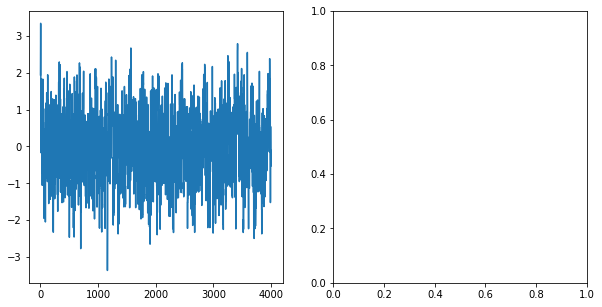

In [492]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize =(10,5))
axes[0].plot(np.arange(len(samples)),samples)

In [489]:
tfd.Bernoulli(0.5).sample()

array(1, dtype=int32)

4    726
2    221
3     48
1      5
dtype: int64


<BarContainer object of 4 artists>

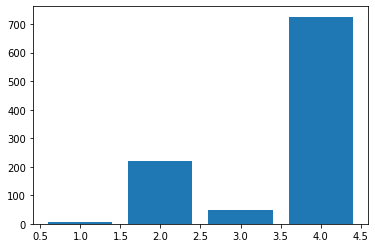

In [441]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)




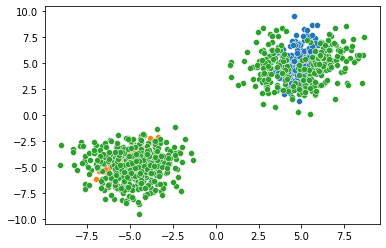

In [442]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

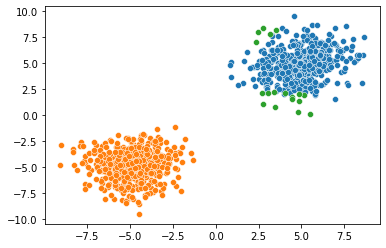

In [426]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

In [289]:
len(allocs_out)

59

In [24]:
for it in range(len(uniq_vals_out)):
    x, y = np.unique(allocs_out[it], return_counts=True)
    plt.bar(x, y)
    plt.show()
    time.sleep(0.1)
    plt.clf()



NameError: name 'uniq_vals_out' is not defined

In [398]:
uniq_vals_out[-1]

array([[[ -5.40031242,   4.59051576,  -2.21646291],
        [ -4.92818571,  -2.21646291,   3.14354902]],

       [[  5.23490151,   0.94278471,   0.85879738],
        [  4.90949715,   0.85879738,   0.99364757]],

       [[  2.60566519,   2.05183045,   0.89785376],
        [  0.74741246,   0.89785376,   0.52670914]],

       [[ 27.43785451,   1.84976546,  -0.85518931],
        [-26.46187083,  -0.85518931,   1.18629589]],

       [[  0.49824473,   0.7127579 ,   0.71751763],
        [  3.17319085,   0.71751763,   1.00301318]]])

In [401]:
uniq_vals_recorded

array([[[  6.81606773,   5.52619875,   1.98871782],
        [ -7.17253347,   1.98871782,   0.90794096]],

       [[  5.70883156,   0.22854679,  -0.53826318],
        [ -5.59667526,  -0.53826318,   2.92193712]],

       [[ -0.12405374,   5.31443725,   2.48442401],
        [ -0.12081239,   2.48442401,   3.82058377]],

       [[ 22.56493602,   2.04043928,   0.34560798],
        [-23.03856359,   0.34560798,   0.57786211]],

       [[ 35.21760947,   4.08483818,  -1.72437264],
        [-35.28132296,  -1.72437264,   1.10886362]]])